Setting refAnt: CS201HBA0
Loaded 58 antennas, 3595 times, 34 directions
Setting refAnt: CS201HBA0
flagged ['CS201HBA1', 'CS201HBA0', 'CS021HBA1', 'CS021HBA0', 'CS011HBA0', 'CS011HBA1', 'CS030HBA1', 'CS030HBA0', 'RS406HBA', 'RS307HBA', 'CS004HBA0', 'CS004HBA1', 'RS106HBA', 'CS026HBA0', 'CS026HBA1', 'CS301HBA0', 'CS301HBA1', 'CS101HBA0', 'CS101HBA1', 'CS024HBA0', 'CS024HBA1', 'CS401HBA0', 'CS032HBA1', 'CS032HBA0', 'CS028HBA0', 'CS028HBA1', 'CS001HBA1', 'CS001HBA0', 'RS503HBA', 'CS103HBA0', 'CS103HBA1', 'CS003HBA1', 'CS003HBA0', 'RS306HBA', 'CS002HBA0', 'CS002HBA1', 'RS205HBA', 'CS501HBA0', 'CS501HBA1', 'RS305HBA', 'CS005HBA1', 'CS005HBA0', 'CS006HBA0', 'CS006HBA1', 'CS302HBA1', 'CS302HBA0', 'CS017HBA0', 'CS017HBA1', 'CS031HBA0', 'CS031HBA1']
Setting refAnt: CS401HBA1
Loaded 8 antennas, 3595 times, 34 directions
Setting refAnt: CS401HBA1
flagged ['s1', 's2', 's251', 's252', 's253', 's254', 's8', 's23', 's3', 's10', 's5', 's7', 's9', 's6', 's27', 's22', 's26', 's15', 's17', 's281', 's24', 

C:\Users\josh\Anaconda3\envs\compute\lib\site-packages\ipykernel_launcher.py:100: RuntimeWarning: divide by zero encountered in log



splitting over directions


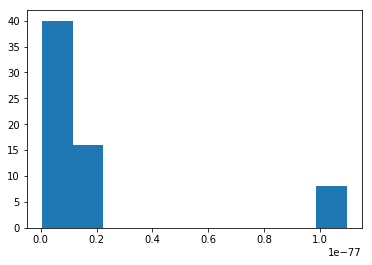

In [1]:
import numpy as np
from scipy.integrate import simps
import dask.array as da
from dask import delayed
from dask.multiprocessing import get
from InitialModel import turbulentPerturbation

def doModelingError(rays,alphaTCI):
    N1,N2, _ , Ns = rays.shape
    alphavec = np.zeros(Ns,dtype=np.double)
    R = np.zeros([N1,N2],dtype=np.double)
    j = 0
    while j < N1:
        k = 0
        while k < N2:
            x = rays[j,k,0,:]
            y = rays[j,k,1,:]
            z = rays[j,k,2,:]
            s = rays[j,k,3,:]
            alphavec *= 0
            idx = 0
            while idx < Ns:
                alphavec[idx] += alphaTCI.interp(x[idx],y[idx],z[idx])
                idx += 1

            alphavec_ = (1 - alphavec)**(5./2.)
            alphavec *= alphavec
            alphavec *= alphavec
            alphavec /= alphavec_
            R[j,k] += simps(alphavec,s)
            k += 1
        j += 1
    R /= 8.
    return R
                

def modelingError(rays,neTCI,frequency):
    '''For each ray do the forward equation using ref antenna i0'''
    Na,Nt,Nd, _, Ns = rays.shape
    Ct = np.zeros([Na,Nt,Nd,4],dtype=np.double)
    n_p = 1.240e-2*(frequency)**2
    i = 0
    while i < 4:
        dM = turbulentPerturbation(neTCI)
        alphaTCI = neTCI.copy()
        alphaTCI.m += dM.ravel('C')
        alphaTCI.m /= n_p
        if Na < Nd:
            #do over antennas
            Ct[:,:,:,i] = np.stack([doModelingError(rays[i,:,:,:,:],alphaTCI) for i in range(Na)],axis=0)
        else:
            #do over directions
            Ct[:,:,:,i] = np.stack([doModelingError(rays[:,:,k,:,:],alphaTCI) for k in range(Nd)],axis=2)
        i += 1
    Ct *= n_p
    Ct = np.var(Ct,axis=3)
    return Ct

def modelingError_dask(rays,neTCI,frequency):
    '''For each ray do the forward equation using ref antenna i0'''
    Na,Nt,Nd, _, Ns = rays.shape
    Ct = np.zeros([Na,Nt,Nd,4],dtype=np.double)
    n_p = 1.240e-2*(frequency)**2
    i = 0
    while i < 4:
        dM = turbulentPerturbation(neTCI)
        alphaTCI = neTCI.copy()
        alphaTCI.m += dM.ravel('C')
        alphaTCI.m /= n_p
        if Na < Nd:
            #do over antennas
            Ct[:,:,:,i] = da.stack([da.from_delayed(delayed(doModelingError)(rays[i,:,:,:,:],alphaTCI),(Nt,Nd),dtype=np.double) for i in range(Na)],axis=0).compute(get=get)
        else:
            #do over directions
            Ct[:,:,:,i] = da.stack([da.from_delayed(delayed(doModelingError)(rays[:,:,k,:,:],alphaTCI),(Na,Nt),dtype=np.double) for k in range(Nd)],axis=2).compute(get=get)
        i += 1
    Ct *= n_p
    Ct = np.var(Ct,axis=3)
    return Ct
    
def test_modelingError():
    from TricubicInterpolation import TriCubic
    from RealData import DataPack
    from AntennaFacetSelection import selectAntennaFacets
    from CalcRays import calcRays
    datapack = DataPack(filename="output/test/datapackObs.hdf5")
    datapackSel = selectAntennaFacets(8, datapack, antIdx=-1, dirIdx=-1, timeIdx = [0])
    antennas,antennaLabels = datapackSel.get_antennas(antIdx = -1)
    patches, patchNames = datapackSel.get_directions(dirIdx = -1)
    times,timestamps = datapackSel.get_times(timeIdx=[0])
    Na = len(antennas)
    Nt = len(times)
    Nd = len(patches)  
    fixtime = times[Nt>>1]
    phase = datapack.getCenterDirection()
    arrayCenter = datapack.radioArray.getCenter()
    neTCI = TriCubic(filename="output/test/neModel.hdf5")
    rays = calcRays(antennas,patches,times, arrayCenter, fixtime, phase, neTCI, datapack.radioArray.frequency, True, 1000, 1000)
    K_ne = np.mean(neTCI.m)
    neTCI.m = np.log(neTCI.m/K_ne)
    mTCI = neTCI
    i0 = 0
    Ct = modelingError(rays,neTCI,datapack.radioArray.frequency)
    import pylab as plt
    plt.hist(Ct.flatten())
    plt.show()
    
if __name__ == '__main__':
    test_modelingError()